#Análise do Campeões da Corrida de São Silvestre com Python

### Wilson Freitas

github: https://github.com/wilsonfreitas/saosilvestre

In [139]:
from IPython import utils
from IPython.core.display import HTML
import os
def css_styling():
    """Load default custom.css file from ipython profile"""
    base = utils.path.get_ipython_dir()
    styles = "<style>\n%s\n</style>" % (open(css_file,'r').read())
    return HTML(styles)
css_styling()

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import sys
%pylab inline
print('python', sys.version)
print('pandas', pd.__version__)
print('statsmodels', sm.version.full_version)
print('seaborn', sns.__version__)

sns.set_context('talk')
sns.set_style("darkgrid")

Populating the interactive namespace from numpy and matplotlib
python 3.4.1 (default, May 19 2014, 13:10:29) 
[GCC 4.2.1 Compatible Apple LLVM 5.1 (clang-503.0.40)]
pandas 0.16.0
statsmodels 0.6.1
seaborn 0.5.1


Os dados já foram capturados, dê uma olhada no post [Captura de dados da Corrida de São Silvestre com Python—Parte 1](http://blog.aboutwilson.net/posts/2015-01/captura-de-dados-da-corrida-de-sao-silvestre-com-python-parte-1/) para entender como o arquivo `saosilvestre.csv` foi criado.

Os trabalhos começam lendo o arquivo e criando um `DataFrame` no `pandas`.

In [105]:
ss = pd.read_csv('saosilvestre.csv')
ss.dtypes

nome        object
pais        object
corrida      int64
ano          int64
horario     object
tempo       object
percurso     int64
largada     object
chegada     object
dtype: object

As colunas `largarda` e `chegada` não interessam para a análise e apenas para não poluir a visualização eu vou removê-las do `DataFrame`.

In [106]:
ss = ss[['nome', 'pais', 'corrida', 'ano', 'horario', 'tempo', 'percurso']]
ss.head()

,nome,pais,corrida,ano,horario,tempo,percurso
0,Dawit Admasu,Etiópia,90,2014,09:00:00,00:45:04.000,15000
1,Ymer Wude Ayalew,Etiópia,90,2013,08:40:00,00:50:43.000,15000
2,Edwin Kipsang,Quênia,89,2013,09:00:00,00:43:47.000,15000
3,Nancy Kipron,Quênia,89,2013,08:40:00,00:51:58.000,15000
4,Edwin Kipsang,Quênia,88,2012,09:00:00,00:44:05.000,15000


## Formatação dos dados e tratamento de erros

Bem, os dados não veem no formato desejado e possuem diversos erros, visto que os dados não estavam estruturados e provavelmente o preenchimento é manual.
Na medida que fui formatando os dados identifiquei alguns erros no preenchimento dos dados. Dado que o *dataset* não é grande isso fica fácil de observar olhando os dados, no entanto para *datasets* gigantes isso se torna inviável e seria necessário criar mecanismos de validação dos dados.

Bem, vamos a formatação dos dados e correção dos erros.

### Ano preenchido errado

In [107]:
ss[ss.corrida == 90]

,nome,pais,corrida,ano,horario,tempo,percurso
0,Dawit Admasu,Etiópia,90,2014,09:00:00,00:45:04.000,15000
1,Ymer Wude Ayalew,Etiópia,90,2013,08:40:00,00:50:43.000,15000


In [108]:
ss.ix[ss.corrida == 90, 'ano'] = 2014
ss.head()

,nome,pais,corrida,ano,horario,tempo,percurso
0,Dawit Admasu,Etiópia,90,2014,09:00:00,00:45:04.000,15000
1,Ymer Wude Ayalew,Etiópia,90,2014,08:40:00,00:50:43.000,15000
2,Edwin Kipsang,Quênia,89,2013,09:00:00,00:43:47.000,15000
3,Nancy Kipron,Quênia,89,2013,08:40:00,00:51:58.000,15000
4,Edwin Kipsang,Quênia,88,2012,09:00:00,00:44:05.000,15000


### Percurso preenchido errado

Esse erro foi identificado durante a análise, pois foi necessário calcular o pace dos campeões para identificar os *outliers* e assim corrigir o problema.
Portanto, vamos começar convertendo algumas colunas para calcular o pace e com o pace fazer a correção do `percurso`.

In [109]:
ss['tempo']   = pd.to_timedelta(ss['tempo'])
ss['horario'] = pd.to_datetime(ss.apply(lambda x: '%s-12-31 %s' % (x['ano'], x['horario']), axis=1))
ss['data']    = ss.apply(lambda x: datetime.datetime(x['ano'], 12, 31), axis=1)
ss['pace']    = 1000*ss['tempo']/ss['percurso']
ss.dtypes

nome                 object
pais                 object
corrida               int64
ano                   int64
horario      datetime64[ns]
tempo       timedelta64[ns]
percurso              int64
data         datetime64[ns]
pace        timedelta64[ns]
dtype: object

In [110]:
ss.head()

,nome,pais,corrida,ano,horario,tempo,percurso,data,pace
0,Dawit Admasu,Etiópia,90,2014,2014-12-31 09:00:00,00:45:04,15000,2014-12-31,00:03:00.266666
1,Ymer Wude Ayalew,Etiópia,90,2014,2014-12-31 08:40:00,00:50:43,15000,2014-12-31,00:03:22.866666
2,Edwin Kipsang,Quênia,89,2013,2013-12-31 09:00:00,00:43:47,15000,2013-12-31,00:02:55.133333
3,Nancy Kipron,Quênia,89,2013,2013-12-31 08:40:00,00:51:58,15000,2013-12-31,00:03:27.866666
4,Edwin Kipsang,Quênia,88,2012,2012-12-31 09:00:00,00:44:05,15000,2012-12-31,00:02:56.333333


Corredores desse nível tem o pace bem abaixo de 4 minutos, então qualquer valor acima disso vou considerar um erro.
Vamos começar filtrando por paces acima de 4 minutos.

In [111]:
ss[ss.pace > datetime.timedelta(0, 4*60)]

,nome,pais,corrida,ano,horario,tempo,percurso,data,pace
26,Tesfaye Jifar,Etiópia,77,2001,2001-12-31 17:00:00,00:44:15,7300,2001-12-31,00:06:03.698630


Pace de 6 minutos é para aquecimento, portanto conclui-se que o percurso está errado.

In [112]:
ss.ix[ss.pace > datetime.timedelta(0, 4*60), 'percurso'] = 15000
ss['pace'] = 1000*ss['tempo']/ss['percurso']
ss.ix[[26]]

,nome,pais,corrida,ano,horario,tempo,percurso,data,pace
26,Tesfaye Jifar,Etiópia,77,2001,2001-12-31 17:00:00,00:44:15,15000,2001-12-31,00:02:57


Um pace de quase 3 minutos é mais plausível.

### Criando coluna de sexo do corredor

Infelizmente os dados não identificam o sexo do campeão (ou campeã).
Dado que há uma diferença no desempenho do corredor por sexo, é interessante que tenhamos essa classificação.

Já sabemos a priori que o pace feminino é maior do que o pace masculino, de forma que vou ordenar por ano e por pace para definir o sexo pela ordem.
No entanto, nos primórdios a corrida era apenas para homens, de forma que isso nos traz um esforço adicional na formatação.
Como falei, vamos começar ordenando o *dataset*.

In [113]:
ss.sort(['ano', 'pace'], inplace=True)
ss.tail(12)

,nome,pais,corrida,ano,horario,tempo,percurso,data,pace
10,James Kipsang,Quênia,85,2009,2009-12-31 16:55:00,00:44:40,15000,2009-12-31,00:02:58.666666
11,Pasalia Kipkoech Chepkorir,Quênia,85,2009,2009-12-31 16:45:00,00:52:30,15000,2009-12-31,00:03:30
8,Marilson Gomes dos Santos,Brasil,86,2010,2010-12-31 16:55:00,00:44:07,15000,2010-12-31,00:02:56.466666
9,Alice Timbilili,Quênia,86,2010,2010-12-31 15:15:00,00:50:19,15000,2010-12-31,00:03:21.266666
6,Tariku Bekele,Etiópia,87,2011,2011-12-31 17:30:00,00:43:35,15000,2011-12-31,00:02:54.333333
7,Priscah Jeptoo,Quênia,87,2011,2011-12-31 17:10:00,00:48:48,15000,2011-12-31,00:03:15.200000
4,Edwin Kipsang,Quênia,88,2012,2012-12-31 09:00:00,00:44:05,15000,2012-12-31,00:02:56.333333
5,Maurine Kipchumba,Quênia,88,2012,2012-12-31 08:40:00,00:51:42,15000,2012-12-31,00:03:26.800000
2,Edwin Kipsang,Quênia,89,2013,2013-12-31 09:00:00,00:43:47,15000,2013-12-31,00:02:55.133333
3,Nancy Kipron,Quênia,89,2013,2013-12-31 08:40:00,00:51:58,15000,2013-12-31,00:03:27.866666


Tendo o *dataset* ordenado eu agrupo por ano e faço uma contagem, quando tiver apenas 1 ocorrência e preencho com `masculino`, quando tiver 2 ocorrências eu preencho com `['masculino', 'feminino']`.

In [114]:
ss_ano = ss.groupby('ano')
ss_sexo = ss_ano.apply(lambda x: 'masculino' if len(x) == 1 else ['masculino', 'feminino'])
ss_sexo

ano
1925                masculino
1926                masculino
1927                masculino
1928                masculino
1929                masculino
1930                masculino
1931                masculino
1932                masculino
1933                masculino
1934                masculino
1935                masculino
1936                masculino
1937                masculino
1938                masculino
1939                masculino
1940                masculino
1941                masculino
1942                masculino
1943                masculino
1944                masculino
1945                masculino
1946                masculino
1947                masculino
1948                masculino
1949                masculino
1950                masculino
1951                masculino
1952                masculino
1953                masculino
1954                masculino
                ...          
1985    [masculino, feminino]
1986    [masculino, feminino]
1987  

Agora é preciso gerar um vetor *flat* com o sexo dos corredores para criar a coluna sexo.

In [115]:
def flatten(x, l):
    if type(x) is list:
        for e in x:
            flatten(e, l)
    else:
        l.append(x)
sexo = []
flatten(ss_sexo.tolist(), sexo)
ss['sexo'] = sexo
ss.tail()

,nome,pais,corrida,ano,horario,tempo,percurso,data,pace,sexo
5,Maurine Kipchumba,Quênia,88,2012,2012-12-31 08:40:00,00:51:42,15000,2012-12-31,00:03:26.800000,feminino
2,Edwin Kipsang,Quênia,89,2013,2013-12-31 09:00:00,00:43:47,15000,2013-12-31,00:02:55.133333,masculino
3,Nancy Kipron,Quênia,89,2013,2013-12-31 08:40:00,00:51:58,15000,2013-12-31,00:03:27.866666,feminino
0,Dawit Admasu,Etiópia,90,2014,2014-12-31 09:00:00,00:45:04,15000,2014-12-31,00:03:00.266666,masculino
1,Ymer Wude Ayalew,Etiópia,90,2014,2014-12-31 08:40:00,00:50:43,15000,2014-12-31,00:03:22.866666,feminino


### País mau preenchido

Abaixo temos exemplos da coluna pais não preenchida e preenchida com valor inválido.
Esse é o tipo de erro identificado com uma contagem da coluna ou um `unique` da coluna para observar as categorias presentes.

In [116]:
ss[ss['pais'].isnull()]

,nome,pais,corrida,ano,horario,tempo,percurso,data,pace,sexo
129,Alfredo Gomes,NaN,1,1925,1925-12-31 23:40:00,00:23:10,6200,1925-12-31,00:03:44.193548,masculino


In [117]:
ss.ix[ss['pais'].isnull(), 'pais'] = 'Brasil'

In [118]:
ss[ss['pais'] == '-']

,nome,pais,corrida,ano,horario,tempo,percurso,data,pace,sexo
29,Lydia Cheromei,-,76,2000,2000-12-31 15:15:00,00:50:33,15000,2000-12-31,00:03:22.200000,feminino
25,Marizete de Paula Rezende,-,78,2002,2002-12-31 15:15:00,00:54:02,15000,2002-12-31,00:03:36.133333,feminino


In [119]:
ss.ix[ss['pais'] == '-', 'pais'] = ['Quênia', 'Brasil']

In [120]:
ss.ix[[129, 29, 25]]

,nome,pais,corrida,ano,horario,tempo,percurso,data,pace,sexo
129,Alfredo Gomes,Brasil,1,1925,1925-12-31 23:40:00,00:23:10,6200,1925-12-31,00:03:44.193548,masculino
29,Lydia Cheromei,Quênia,76,2000,2000-12-31 15:15:00,00:50:33,15000,2000-12-31,00:03:22.200000,feminino
25,Marizete de Paula Rezende,Brasil,78,2002,2002-12-31 15:15:00,00:54:02,15000,2002-12-31,00:03:36.133333,feminino


Aqui encerramos o tratamento dos dados, vamos a análise.

## Análise dos dados

Vamos começar com uma contagem simples de corredores por país e por sexo.

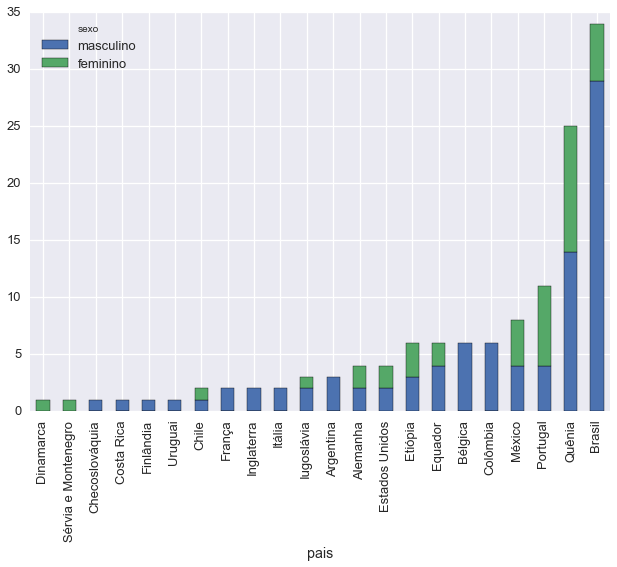

In [121]:
ss_pais = ss.groupby(['pais', 'sexo'])
ss_pais_sexo = ss_pais.sexo.count().unstack().fillna(0)
ss_pais_sexo['total'] = ss_pais_sexo.masculino + ss_pais_sexo.feminino
ss_pais_sexo = ss_pais_sexo.sort(['total', 'masculino'])
ss_pais_sexo[['masculino', 'feminino']].plot(kind='bar', stacked=True);

O gráfico acima é interessante porque mostra que o Quênia colado no Brasil, entretanto, o Brasil ainda é o maior campeão da São Silvestre.
Por outro, a pergunta que me surge é como está o ritmo de vitórias do Quênia e se possível, em quanto tempo ele pode ultrapassar o Brasil em número de vitórias.
Para isso é necessário fazer uma contagem acumulada de vitórias por ano e por país.

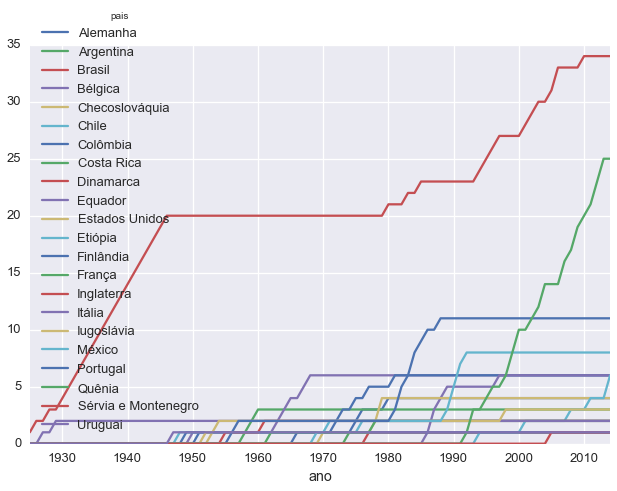

In [122]:
ss_pais_c = ss.groupby(['ano', 'pais']).corrida.count()
ss_pais_c.unstack().fillna(0).cumsum().plot();

O gráfico acima fica poluído porque tem muito pais nanico, vou filtrar pelos 3 maiores: Brasil, Quênia e Portugal.

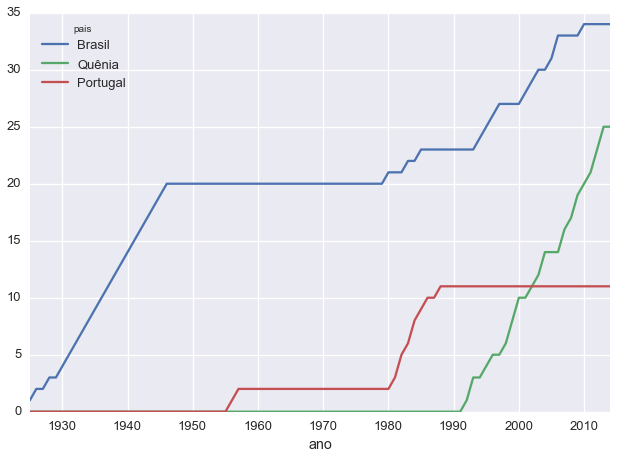

In [123]:
ss_pais_c.unstack()[['Brasil', 'Quênia', 'Portugal']].fillna(0).cumsum().plot();

É possível ver que a curva do Quênia é mais inclinada que a do Brasil e que em mais alguns anos, se nada for feito, o nosso status de campeões vai para o saco.

Abaixo segue um gráfico simples de percurso por ano, onde é observa-se que nos últimos anos a corrida estabilizou nos 15K.

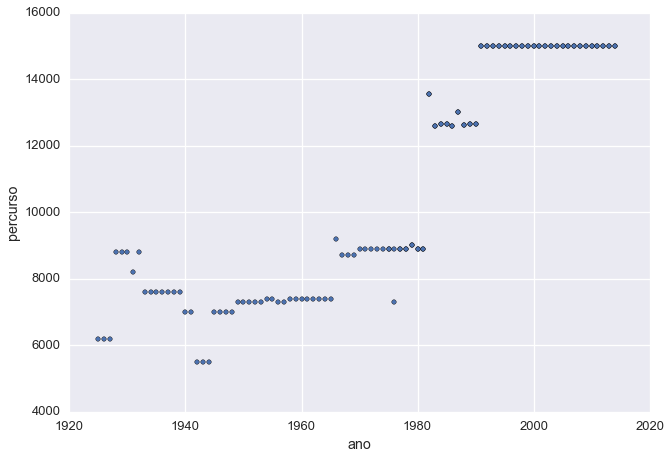

In [124]:
ss.plot(x='ano', y='percurso', kind='scatter');

Abaixo temos um gráfico de pace por sexo.
Note que para as corridas abaixo de 10K há uma variância significativa, e uma mistura entre pace masculino e feminino.
Para as corridas abaixo de 10K já fica mais claro a diferença entre os dois.

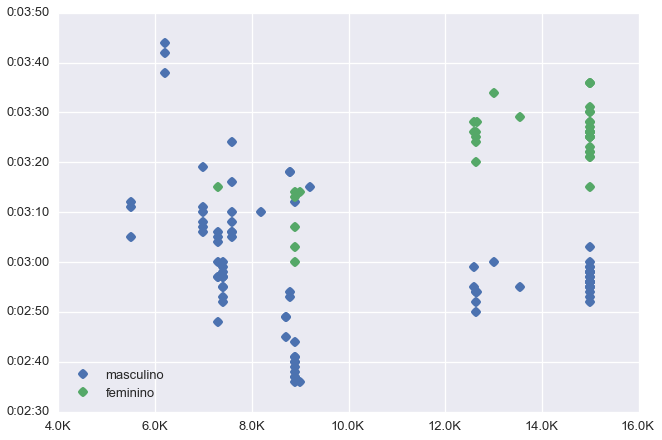

In [125]:
ss_pace = ss.ix[:,['sexo', 'ano', 'pace', 'percurso']]
ss_pace['pace'] = ss_pace.pace.astype('timedelta64[s]')
fig = plt.figure(); ax = fig.add_subplot(111)
masc = ss_pace.query('sexo == "masculino"'); fem = ss_pace.query('sexo == "feminino"')

ax.plot(masc.percurso, masc.pace, 'o', label='masculino')
ax.plot(fem.percurso, fem.pace, 'o', label='feminino')

pace_formatter = matplotlib.ticker.FuncFormatter(lambda x, pos: str(datetime.timedelta(seconds=x)))
dist_formatter = matplotlib.ticker.FuncFormatter(lambda x, pos: str(x/1000) + 'K')
ax.xaxis.set_major_formatter(dist_formatter)
ax.yaxis.set_major_formatter(pace_formatter)
plt.legend(loc=3)
plt.show()

Como eu quero avaliar a influência do clima no desempenho do corredor eu vou considerar apenas as corridas com percurso acima de 12K.

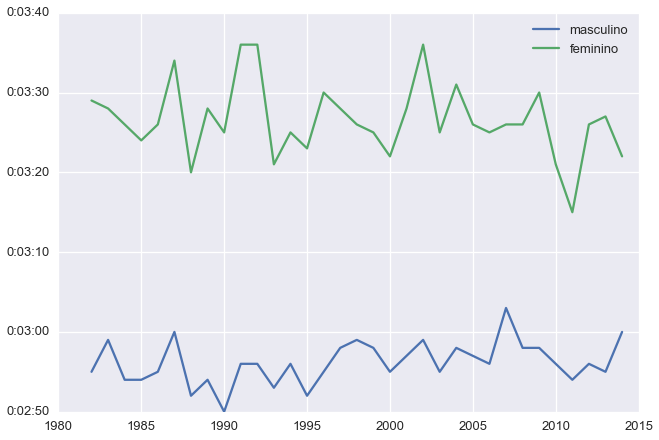

In [126]:
ss_long = ss.query('percurso > 12000')
ss_long.ix[:,'pace'] = ss_long['pace'].astype('timedelta64[s]')

fig = plt.figure(); ax = fig.add_subplot(111)
masc = ss_long.query('sexo == "masculino"'); fem = ss_long.query('sexo == "feminino"')

ax.plot(masc.ano, masc.pace, label='masculino'); ax.plot(fem.ano, fem.pace, label='feminino')

pace_fmt = matplotlib.ticker.FuncFormatter(lambda x,p: str(datetime.timedelta(seconds=x)))
ax.yaxis.set_major_formatter(pace_fmt)
plt.legend()
plt.show()

### Carregando os dados de temperatura

Os dados de temperatura foram obtidos no site do INMET.

In [127]:
dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y')
temp = pd.read_csv('temperatura.csv', parse_dates=['Data'], date_parser=dateparse)
print(temp.dtypes)
temp.head()

Data                    datetime64[ns]
TempMaximaMedia                float64
TempCompensadaMedia            float64
TempMinimaMedia                float64
UmidadeRelativaMedia           float64
dtype: object


,Data,TempMaximaMedia,TempCompensadaMedia,TempMinimaMedia,UmidadeRelativaMedia
0,1961-12-31,27.177419,20.721290,17.083871,81.185484
1,1962-12-31,24.483871,19.985161,17.106452,87.024194
2,1963-12-31,26.806452,20.597419,16.641935,75.088710
3,1964-12-31,24.516129,19.642581,16.338710,83.532258
4,1965-12-31,26.412903,21.985161,19.000000,81.612903


Observando a evolução da temperatura e da umidade ao longo dos anos.
Em 50 anos a temperatura média subiu uns 3 graus, em média e a umidade caiu quase uns 15 pontos.
A coisa não parece boa!

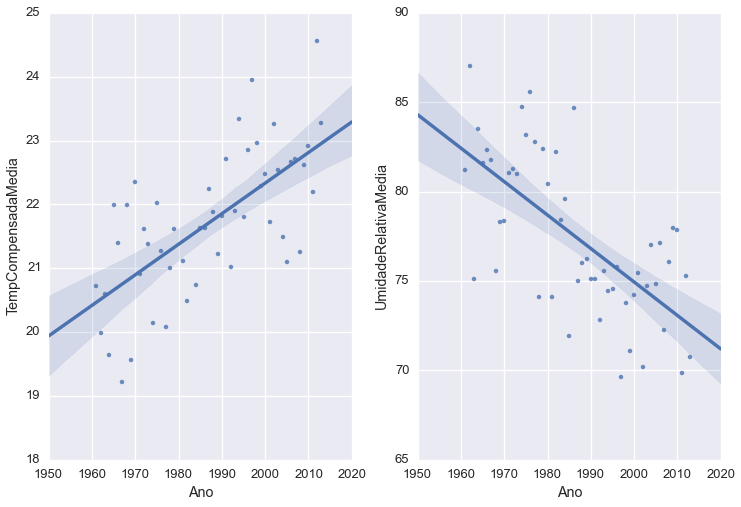

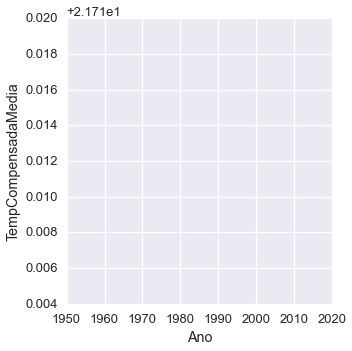

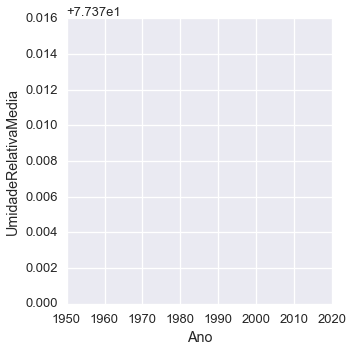

In [128]:
temp['Ano'] = temp.Data.apply(lambda x: x.year)
f, (ax1, ax2) = plt.subplots(1, 2)
sns.lmplot("Ano", "TempCompensadaMedia", temp, ax=ax1)
sns.lmplot("Ano", "UmidadeRelativaMedia", temp, ax=ax2)
f.tight_layout();

### Juntando os datasets

Vamos juntar os *datasets* dos campeões e da temperatura para relacionar as medidas de temperatura com o pace dos corredores.

In [129]:
ss_temp = pd.merge(ss_long, temp, left_on='data', right_on='Data')
ss_temp.head().transpose()

,0,1,2,3,4
nome,Carlos Lopes,Rosa Mota,João da Mata,Rosa Mota,Carlos Lopes
pais,Portugal,Portugal,Brasil,Portugal,Portugal
corrida,58,58,59,59,60
ano,1982,1982,1983,1983,1984
horario,1982-12-31 23:05:00,1982-12-31 23:05:00,1983-12-31 23:05:00,1983-12-31 23:05:00,1984-12-31 23:05:00
tempo,0 days 00:39:41,0 days 00:47:21,0 days 00:37:39,0 days 00:43:44,0 days 00:36:43
percurso,13548,13548,12600,12600,12640
data,1982-12-31 00:00:00,1982-12-31 00:00:00,1983-12-31 00:00:00,1983-12-31 00:00:00,1984-12-31 00:00:00
pace,175,209,179,208,174
sexo,masculino,feminino,masculino,feminino,masculino


Abaixo temos uns gráficos relacionando o pace com a temperatura e com a umidade, em ambos os casos estamos separando por sexo.
Nota-se que o sexo feminino apresenta pouca tendência em ambos os casos enquanto o sexo masculino apresenta alguma tendência.
Precisamos agora avaliar se essa tendência é significativa.

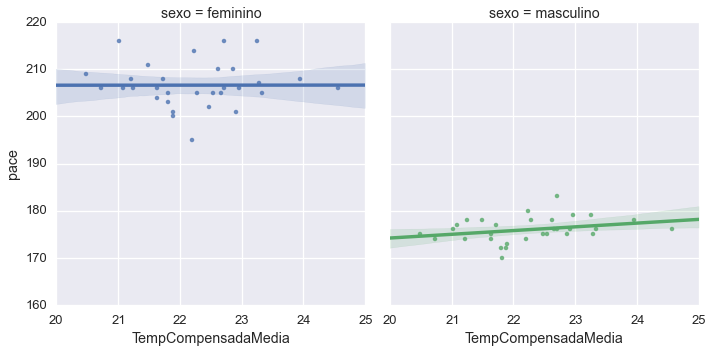

In [130]:
sns.lmplot("TempCompensadaMedia", "pace", ss_temp, hue='sexo', col='sexo');

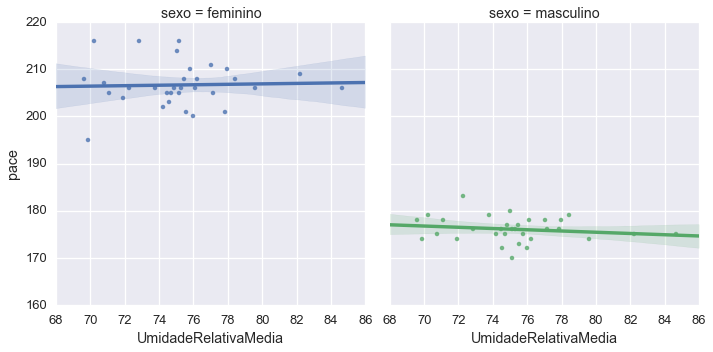

In [131]:
sns.lmplot("UmidadeRelativaMedia", "pace", ss_temp, hue='sexo', col='sexo');

Para avaliar se a tendência observada é significativa vamos rodar uma regressão dos dados e avaliar a significância do coeficiente angular da regressão.

In [132]:
ss_temp_aux = ss_temp.query("sexo == 'masculino'")
X = ss_temp_aux.TempCompensadaMedia
X = sm.add_constant(X)
y = ss_temp_aux.pace/60
mod = sm.OLS(y, X, missing='drop')
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   pace   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     2.562
Date:                Fri, 10 Apr 2015   Prob (F-statistic):              0.120
Time:                        08:21:22   Log-Likelihood:                 55.056
No. Observations:                  31   AIC:                            -106.1
Df Residuals:                      29   BIC:                            -103.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
const                   2.6382    

In [133]:
ss_temp_aux = ss_temp.query("sexo == 'masculino'")
X = ss_temp_aux.UmidadeRelativaMedia
X = sm.add_constant(X)
y = ss_temp_aux.pace/60
mod = sm.OLS(y, X, missing='drop')
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   pace   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.8682
Date:                Fri, 10 Apr 2015   Prob (F-statistic):              0.359
Time:                        08:21:22   Log-Likelihood:                 55.743
No. Observations:                  32   AIC:                            -107.5
Df Residuals:                      30   BIC:                            -104.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                    3.0993 

Em ambos os casos os coeficientes foram não significativos, indicando que não há relação entre o clima e o desempenho dos campeões da São Silvestre.